In [1]:
#### COLAB ONLY CELL
from google.colab import drive
drive.mount('/content/gdrive')
# drive.mount('/content/gdrive',force_remount=True)
%cd /content/gdrive/MyDrive/COMEXT
%pip install -q powerlaw

Mounted at /content/gdrive
/content/gdrive/MyDrive/COMEXT


In [2]:
import hashlib, random, math, os, sys, pickle, time, zipfile, io, json#, powerlaw #,eurostat
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm, trange
from networkx.classes.function import degree
import matplotlib.pyplot as plt
from matplotlib import cm

sys.path.append('/content/gdrive/MyDrive/COMEXT/comext_graph_analysis/src')
import graph_analysis as g

In [56]:
def load_filtered_data(table, save=False, verbose=1, force_reload=False, sorted=True, **params):
    """"
    load_filtered_data("full", save=True, force_reload=True, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
                             years=[2012], months=None, product=["0"+str(i) for i in range(600,699)], flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")

    load_filtered_data(table:str, save:bool, types:dict(type), columns:list, group_by_prod_code:bool, 
            n_digits:int, years=list(int), months=list(int)|None|"all", product:"all"|list(str), 
            flow:1|2|"all", trade_type:"I"|"E"|"all",  declarant_iso:str|"all", partner_iso:str|"all")
    """
    
    if verbose:
        print("loading",table,end=": ")

    def get_params_str_hash(params):
        str_params = {x:params[x] for x in params if x != "types"}
        # str_params = params
        # return str(str_params).replace("{","").replace("}","").replace("': ","_").replace("[","").replace("]","").replace(", ","_").replace("'","").replace("<class ","").replace(">","")
        return hashlib.sha256(str(str_params).encode("UTF_8")).hexdigest()

    def group_by_prod_code(table,**params):
        df = table.copy()
        column = df.columns[0]
        df[column] = df[column].str[:params["n_digits"]]
        return df.groupby(params["columns"][:-2],as_index=False).sum()
    
    if not force_reload and os.path.exists(f"./data-samples/manual/{table}/{table}__{get_params_str_hash(params)}.parquet"):
        if not os.path.exists(f"./data-samples/manual/{table}/"):
            os.makedirs(f"./data-samples/manual/{table}/")
        if verbose:
            print("loading existing...",end=" ")
        df = pd.read_parquet(f"./data-samples/manual/{table}/{table}__{get_params_str_hash(params)}.parquet")
        if verbose:
            print("Table loaded")
        return df, None
    else:
        prod_code_df = params["columns"][0]

        def build_filters(df,params,table,name,prod_code_df):
            filters = pd.Series([True for i in range(df.shape[0])])
            if isinstance(params["product"],list):
                filter_prod = ~filters.copy()
                not_f = []
                for p in params["product"]:
                    mask = (df[prod_code_df] == p)
                    if not mask.any():
                        not_f.append(p)
                    filter_prod = filter_prod | mask
                if verbose==2 and len(not_f) > 0:
                    print(','.join(not_f),f"not found in {table}{name}",end=", ")
                filters = filters & filter_prod
            elif params["product"] != "all":
                mask = (df[prod_code_df] == params["product"])
                if verbose==2 and not mask.any():
                    print(f"{params['product']} not found in {table}{name}",end=", ")
                filters = filters & mask
            if params["flow"] != "all":
                filters = filters & (df.FLOW == params["flow"])
            if table == "full" and params["trade_type"] != "all":
                filters = filters & (df.TRADE_TYPE == params["trade_type"])
            if isinstance(params["declarant_iso"],list):
                filter_dec = ~filters.copy()
                for p in params["declarant_iso"]:
                    mask = (df["DECLARANT_ISO"] == p)
                    if verbose==2 and not mask.any():
                        print(f"{p} not found in {table}{name}",end=", ")
                    filter_dec = filter_dec | mask
                filters = filters & filter_dec
            elif params["declarant_iso"] != "all":
                mask = (df["DECLARANT_ISO"] == params["declarant_iso"])
                if verbose==2 and not mask.any():
                    print(f"{params['declarant_iso']} not found in {table}{name}",end=", ")
            if isinstance(params["partner_iso"],list):
                filter_dec = ~filters.copy()
                for p in params["partner_iso"]:
                    mask = (df["PARTNER_ISO"] == p)
                    if verbose==2 and not mask.any():
                        print(f"{p} not found in {table}{name}",end=", ")
                    filter_dec = filter_dec | mask
                filters = filters & filter_dec
            elif params["partner_iso"] != "all":
                mask = (df["PARTNER_ISO"] == params["partner_iso"])
                if verbose==2 and not mask.any():
                    print(f"{params['partner_iso']} not found in {table}{name}",end=", ")
            
            if verbose==2 and not filters.any():
                print(f"\n\tempty df for {table}{name}")

            return filters

        if table not in ["full","tr","tr_intra_"]:
            raise Exception("table not valid")
        df = pd.DataFrame(columns=params["columns"])
        for y in tqdm(params["years"],leave=False):
            if verbose:
                print(y,end=" ")
            if params["months"] is None:
                df_y = pd.read_parquet(f"./data-samples/{table}/Years/{table}{y}52.parquet",columns=params["columns"])
                if "group_by_prod_code" in params.keys() and params["group_by_prod_code"]:
                    df_y_filtered = group_by_prod_code(df_y[build_filters(df_y,params,table,str(y)+"52",prod_code_df)].astype(params["types"]),**params)
                else:
                    df_y_filtered = df_y[build_filters(df_y,params,table,str(y)+"52",prod_code_df)].astype(params["types"])
                df = pd.concat([df,df_y_filtered])
                del df_y, df_y_filtered
            elif params["months"] == "all":
                for m in tqdm(range(1,13),leave=False):
                    # if verbose:
                    #     print(str(m),end=" ")
                    df_ym = pd.read_parquet(f"./data-samples/{table}/Months/{table}{y*100+m}.parquet",columns=params["columns"])
                    if "group_by_prod_code" in params.keys() and params["group_by_prod_code"]:
                        df_y_filtered = group_by_prod_code(df_ym[build_filters(df_ym,params,table,str(y*100+m),prod_code_df)].astype(params["types"]),**params)
                    else:
                        df_y_filtered = df_ym[build_filters(df_ym,params,table,str(y*100+m),prod_code_df)].astype(params["types"])
                    df = pd.concat([df,df_y_filtered])
                del df_ym, df_y_filtered
            else:
                for m in params["months"]:
                    if verbose:
                        print(str(m),end=" ")
                    df_ym = pd.read_parquet(f"./data-samples/{table}/Months/{table}{y*100+m}.parquet",columns=params["columns"])
                    if "group_by_prod_code" in params.keys() and params["group_by_prod_code"]:
                        df_y_filtered = group_by_prod_code(df_ym[build_filters(df_ym,params,table,str(y*100+m),prod_code_df)].astype(params["types"]),**params)
                    else:
                        df_y_filtered = df_ym[build_filters(df_ym,params,table,str(y*100+m),prod_code_df)].astype(params["types"])
                    df = pd.concat([df,df_y_filtered])
                del df_ym, df_y_filtered
        if df.shape[0] == 0:
            if verbose:
                print("\n\tEmpty table")
            return df
        else:
            if sorted:
                print("Pippo")
                df_out = df.groupby(params["columns"][:-2],as_index=False).sum().sort_values(params["columns"][-1],ascending=False).reset_index(drop=True)
            else:
                df_out = df.groupby(params["columns"][:-2],as_index=False).sum().reset_index(drop=True)
            str_save = f"./data-samples/manual/{table}/{table}__{get_params_str_hash(params)}.parquet"
            if save:
                try:
                    df_out.to_parquet(str_save)
                    if verbose:
                        print(",\t Table loaded")
                    return df_out.astype(params["types"]), str_save
                except:
                    if verbose:
                        print("\nFailed saving",end="")
                        print(", Table loaded")
                    return df_out.astype(params["types"]), str_save
            else:
                return df_out.astype(params["types"]), str_save

In [57]:
df_com, _ = load_filtered_data("full", save=True, force_reload=True, columns=g.full_columns, types=g.full_types, group_by_prod_code=False, n_digits=2,
                         years=[2001], months=None, product="all", flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")
df_wto = pd.read_parquet("data-samples/wto/wto_comextify/wto_df_2001_tot.parquet")

loading full: 

  0%|          | 0/1 [00:00<?, ?it/s]

2001 Pippo
,	 Table loaded


In [16]:
# for f in tqdm(os.listdir("data-samples/wto/wto_comextify/")):
#     df_wto = pd.read_parquet("data-samples/wto/wto_comextify/"+f)
#     df_wto_tot = df_wto.groupby(['DECLARANT_ISO', 'PARTNER_ISO', 'FLOW', 'PERIOD'],as_index=False).sum()
#     df_wto_tot["PRODUCT_CPA2_1"] = "TOTAL"
#     df_wto_2 = pd.concat([df_wto,df_wto_tot[df_wto.columns]],axis=0)
#     df_wto_2.to_parquet("data-samples/wto/wto_comextify/"+f.replace(".parquet","_tot.parquet"))

  0%|          | 0/20 [00:00<?, ?it/s]

In [59]:
df_merge = pd.merge(df_com,df_wto,on=['PRODUCT_CPA2_1', 'DECLARANT_ISO', 'PARTNER_ISO', 'FLOW', 'PERIOD'])

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


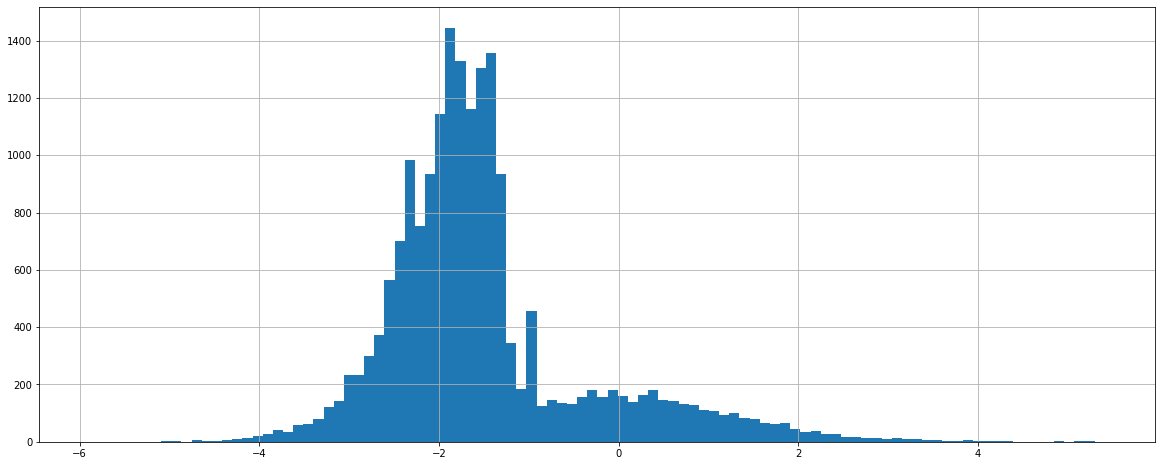

In [64]:
np.log10((df_merge.VALUE_IN_EUROS_y - df_merge.VALUE_IN_EUROS_x)/(df_merge.VALUE_IN_EUROS_x)).hist(bins=100,figsize=(20,8))

In [66]:
%%shell
for y in {2001..2020}
do
    mv "data-samples/wto/Years/wto_${y}52.parquet" "data-samples/wto/Years/wto${y}52.parquet"
done